# Simplicity Bag of Words with Term Frequency (TF) and Inverse Document Frequency (IDF) and Singular Value Decomposition

### Load Basic Packages

In [1]:
!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 12.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load the data for the homework

In [27]:
df = pd.read_csv("./spam.csv", encoding='utf-8')
print(df.head())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### We need to use integers for spam and ham 

In [32]:
mapping = {'spam': 0., 'ham': 1.}
df['v3'] = df['v1'].map(mapping)


In [34]:
print(df.head())

     v1                                                 v2   v3
0   ham  Go until jurong point, crazy.. Available only ...  1.0
1   ham                      Ok lar... Joking wif u oni...  1.0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  0.0
3   ham  U dun say so early hor... U c already then say...  1.0
4   ham  Nah I don't think he goes to usf, he lives aro...  1.0


### Get the list of strings and lables

In [46]:
documents = df['v2'].to_list()
Y = df['v3'].to_numpy()

In [ ]:
len(documents)


5572

In [47]:
sum(Y==0)


np.int64(747)

In [10]:
sum(Y==1)

np.int64(4825)

### We have an unbalanced set here what to do?

In [55]:
STOP_WORDS = set(stopwords.words('english'))
STEMMER   = PorterStemmer()

def preprocess(text: str) -> list:
    """
    1. Lower‑case
    2. Tokenise
    3. Remove punctuation & non‑alpha tokens
    4. Remove English stop‑words
    5. Apply Porter stemming
    """
    # 1. + 2. Tokenise and lower‑case
    tokens = word_tokenize(text.lower())
   

    # 3. Remove punctuation & keep only alphabetic tokens
    tokens = [t for t in tokens if t.isalpha()]

    # 4. Remove stop‑words
    tokens = [t for t in tokens if t not in STOP_WORDS]

    # 5. Stemming
    tokens = [STEMMER.stem(t) for t in tokens]

    # Return string given that CountVectorizer uses strings
    return " ".join(tokens)

### Preprocess documents

In [57]:
processed_docs = [preprocess(doc) for doc in documents]
 
print(f"Sample processed doc: {processed_docs[0][:200]}...")

Sample processed doc: go jurong point crazi avail bugi n great world la e buffet cine got amor wat...


### Build a TF‑IDF matrix

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.95,     # ignore very frequent words (e.g. in >95% of docs)
    min_df=2,        # ignore very rare words (in <2 docs)
    stop_words=None, # we already removed them
    norm='l2'        # normalise each row to unit L2 length
)


TfidfVectorizer(max_df=0.95, min_df=2)


In [64]:
X_tfidf = vectorizer.fit_transform(processed_docs)



In [74]:
print(f"TF‑IDF shape: {X_tfidf.shape}")   # (n_docs, n_features)


TF‑IDF shape: (5572, 2982)


### Truncate the vectors of representation from 2982 to 100 

In [77]:
n_components = 100   # adjust as needed
svd = TruncatedSVD(n_components=n_components, random_state=42)



In [23]:
X_svd = svd.fit_transform(X_tfidf)
print(f"LSA (SVD) shape: {X_svd.shape}")   # (n_docs, n_components)

LSA (SVD) shape: (5572, 100)


### Normalise again (common in LSA to make the vectors unit length)

In [69]:
X_svd_norm = Normalizer(copy=False).fit_transform(X_svd)


In [25]:
X_svd_norm.shape

(5572, 100)

In [72]:
Y.shape

(5572,)

### From Here you need to use the Logistic Regression Scratch and Sklearn 

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_svd_norm, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [111]:
y_pred = model.predict(X_test)

#now let's see the metrics to see how well our model performed
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83       150
         1.0       0.96      0.99      0.98       965

    accuracy                           0.96      1115
   macro avg       0.95      0.87      0.90      1115
weighted avg       0.96      0.96      0.96      1115



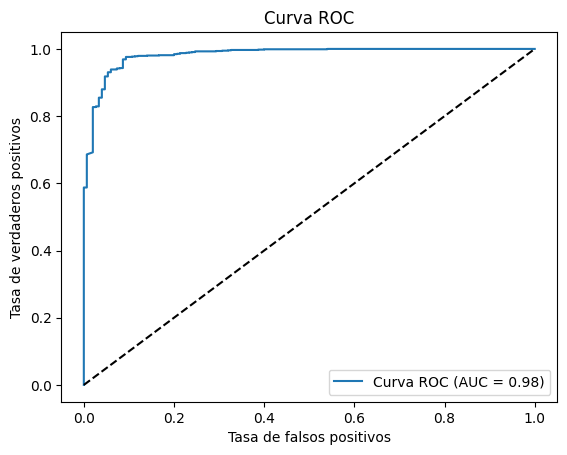

In [157]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()